In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Change default colour scheme:
plt.style.use('seaborn-colorblind')

# Thrombectomy 

### T=0 

The distribution of mRS at time T=0 (i.e. before stroke) from the SAMuel-1 data. 

In [4]:
mrs_prob_dist_t0_treatment = np.array([0.54956819, 0.14895196, 0.0980681 , 0.11769072, 0.06707674, 0.0186443])
# mrs_prob_dist_t0_treatment = np.cumsum(np.concatenate((mrs_prob_dist_t0_treatment,[0.0])))

Convert the mRS distribution into cumulative frequency:

In [5]:
mrs_prob_bins_t0_treatment = np.cumsum(np.concatenate(([0],mrs_prob_dist_t0_treatment)))

In [6]:
mrs_prob_bins_t0_treatment

array([0.        , 0.54956819, 0.69852015, 0.79658825, 0.91427897,
       0.98135571, 1.00000001])

### T = 8 hours 

Collect "untreated" mRS distribution, i.e. mRS at time T=8hrs.
_Presumably_ this only includes patients when no thrombolysis or thrombectomy has been performed.

Data from Goyal+2016[1], Figure 1 (A Overall, Control population). mRS=6 is excluded and P(mRS=6)=0.189.

[1] _"Endovascular thrombectomy after large-vessel ischaemic stroke: a meta-analysis of individual patient data from five randomised trials"_

In [7]:
#from golye's control population (figure 1a)

mrs_prob_dist_no_treatment_ect = [0.05, 0.079, 0.136, 0.164, 0.247, 0.135]

Convert to cumulative frequency:

In [8]:
mrs_prob_bins_no_treatment_ect = np.cumsum(np.concatenate(([0],mrs_prob_dist_no_treatment_ect)))

# Need to normalise because it currently doesn't add up to 1 (non-zero mRS=6 is excluded).
mrs_prob_bins_no_treatment_ect = mrs_prob_bins_no_treatment_ect/mrs_prob_bins_no_treatment_ect[-1]

mrs_prob_bins_no_treatment_ect

array([0.        , 0.06165228, 0.15906289, 0.32675709, 0.52897657,
       0.83353884, 1.        ])

Test some probability "x" - which mRS bin does it fall into?

In [9]:
#x = np.random.rand()
x = 0.5

np.digitize(x, mrs_prob_bins_no_treatment_ect, right=True)-1

3

---

## Model 1

Assume log odds = 0 at $T_{NE}$.

Each mRS has different values of _a_, _b_, and _A_, and so the variables `a`, `b`, and `A` are arrays - index 0 for mRS=0 values etc.

### Find a

At T = 0, log odds = a (see Equation 4). Find the value of _a_ by using Equation 5 above:

$$ a = \log[P(m\leq x|T=0hr)] - \log[P(m>x|T=0hr)] - \log[P(m\leq x|T_{NE})] + \log[P(m>x|T_{NE})]$$

Define some things so that:

$$ a = p1 - p2 - p3 + p4 $$

All of these right-hand-side RHS probabilities are known from the input data. 

The probabilities are not calculated using the `mrs_prob_bins_t0_treatment` and `mrs_prob_bins_no_treatment_ect` defined earlier as those arrays contain an extra 0.0 at the beginning, and we don't want to set mRS=0 to probabilities 0.0.

mRS<=5 is excluded from the calculations because P(mRS<=5)=1.0 at all times, and so values for _a_, _b_ and _A_ cannot be found. Instead a straight horizontal line is plotted to show mRS<=5.

In [10]:
F_ect = np.cumsum(mrs_prob_dist_no_treatment_ect)

F_ect = F_ect/F_ect[-1]

print(F_ect)

p1_ect = np.log(np.cumsum(mrs_prob_dist_t0_treatment)[:-1])
p2_ect = np.log(1 - np.cumsum(mrs_prob_dist_t0_treatment)[:-1])
p3_ect = np.log(F_ect[:-1])
p4_ect = np.log(1 - F_ect[:-1])

a_ect = p1_ect-p2_ect - p3_ect+p4_ect

print(a_ect)

[0.06165228 0.15906289 0.32675709 0.52897657 0.83353884 1.        ]
[2.92153651 2.5054781  2.08799482 2.25100125 2.35247676]


### Find b 

At T = 8hr (i.e. $T=T_{NE}$), log odds = 0 because the RHS of Equation 5 above cancels to zero. i.e. at T_0, odds=1. 

$$ b = -\frac{a}{8} $$

In [11]:
b_ect = -a_ect/(8*60)

### Find A 

_A_ combines _a_ and all of the $time_to_no_effect$ terms - see the difference between Equations 5 and 6 above.  


$$ A = a + \log[P(m\leq x|T_{NE})] - \log[P(m>x|T_{NE})]$$

In [58]:
A_ect = a_ect+p3_ect-p4_ect

A_ect

array([0.19892616, 0.84026084, 1.36510567, 2.36703756, 3.96339506])

### Plot log odds as function of time

Each mRS value has a different _a_ and _b_ to calculate its log-odds. 

_a_ is the y-intercept and _b_ is the gradient.

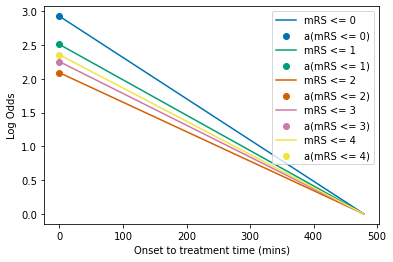

In [13]:
t = np.arange(0,8*60)

for i,a_i in enumerate(a_ect):
    
    plt.plot(t, a_i + b_ect[i]*t, '-', label = f'mRS <= {i}')
    
    plt.scatter(0, a_i, label= f'a(mRS <= {i})')
    
plt.legend(loc='best')

plt.ylabel('Log Odds')

plt.xlabel('Onset to treatment time (mins)')

plt.show()

### Plot P as function of time 

Each mRS value has a different _A_ and _b_ to calculate its probability with time.

Because all of the calculations so far have used cumulative probability $P(m\leq x|T)$, the lines should be viewed as being stacked on top of each other. 

We started with the data at t=0 and t=$time_to_no_effect$ and have calculated the lines in between.

Basic plot:

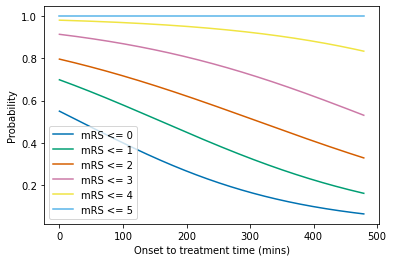

In [14]:
t = np.arange(0,8*60)

for i,A_i in enumerate(A_ect):
    
    plt.plot(t, np.exp(A_i + b_ect[i]*t)/(1+np.exp(A_i + b_ect[i]*t)), '-', label = f'mRS <= {i}')
    
plt.plot(t, [1.0 for x in t], '-', label = 'mRS <= 5')

plt.ylabel('Probability')

plt.xlabel('Onset to treatment time (mins)')

plt.legend(loc='best')

plt.show()

The same lines plotted with extra annotations:

In [15]:
def plot_probs(A_ect,b_ect,t,mrs_prob_bins_t0_treatment,mrs_prob_bins_no_treatment,colour_bins=1,mark_data_ect=0,mark_data_oly=0,plot_mRS5=1):
    """
    Plot cumulative probability against time with fancier labelling.
    
    Inputs:
    A_ect         - list or np.array. Contains values of A for P(t,A,b).
    b_ect         - list or np.array. Contains values of b for P(t,A,b).
    t             - list or np.array. Time steps.
    mrs_prob_bins_t0_treatment        - list or np.array. Cumulative probability bins at t=0.
    mrs_prob_bins_no_treatment        - list or np.array. Cumulative probability bins at t=time_to_no_effect.
    colour_bins   - int, 0 or 1. Whether to colour the gaps between P(t) lines.
    mark_data_ect - int, 0 or 1. Whether to mark the input data for thrombectomy.
    mark_data_oly - int, 0 or 1. Whether to mark the input data for thrombolysis.
    plot_mRS5     - int, 0 or 1. Whether to draw P(mRS<=5) along the top.
    
    """
    if plot_mRS5>0:
        # P(mRS<=5)=1.0 at all times, so we cannot define A, a, and b.
        # Instead append to this array a 0.0, which won't be used directly
        # but will allow the "for" loop to go round one extra time.
        A_ect = np.append(A_ect,0.0)
    for i,A_i in enumerate(A_ect):

        # Define the probability line, p_i:
        if i<5:
            p_i = np.exp(A_i + b_ect[i]*t)/(1+np.exp(A_i + b_ect[i]*t))
        else:
            # P(mRS<=5)=1.0 at all times:
            p_i = np.full(t.shape,1.0)
        # Plot it as before and store the colour used:
        l, = plt.plot(t, p_i, '-', label = f'mRS <= {i}')
        colour = l.get_color()

        if mark_data_ect>0:
            # Mark the thrombectomy data at time t=0hr and t=time_to_no_effect.
            # If first marker plotted, then add a label for the legend:
            l_T0 = 'SAMueL data'     if i<1 else None
            l_time_to_no_effect = 'Goyal+2016 data' if i<1 else None
            # (Keep i+1 index because the first value in mrs_prob_bins_t0_treatment is just 0.0):
            plt.scatter(0, mrs_prob_bins_t0_treatment[i+1],
                        marker='o', label=l_T0, facecolor=colour, edgecolor='k')
            plt.scatter(8*60, mrs_prob_bins_no_treatment[i+1],
                        marker='s', label=l_time_to_no_effect, facecolor=colour, edgecolor='k')
            
        if mark_data_oly>0:
            # Mark the thrombolysis data. 
            if i==1:
                # For mRS<=1 only, plot the reference data point.
                ti = np.where(t==1.0*60)
                plt.scatter(t[ti], p_i[ti],
                            marker='D', label='Emberson+2014 data', 
                            facecolor=colour, edgecolor='k')
                
            # Mark the data at time t=6.3hr.
            # If this is the first marker plotted, then add a label for the legend:
            l_time_to_no_effect = 'Lees+2010 data' if i<1 else None
            # (Keep i+1 index because the first value in mrs_prob_bins_t0_treatment is just 0.0):
            plt.scatter(6.3*60, mrs_prob_bins_no_treatment[i+1],
                        marker='X', label=l_time_to_no_effect, facecolor=colour, edgecolor='k')
              
        if colour_bins>0:

            # Fill in the area between this line, p_i, and the line below, p_j.
            # This area marks where mRS <= the given value.
            # If p_j is not defined yet (i=0), set all p_j to zero:
            p_j = p_j if i>0 else np.zeros_like(p_i)
            plt.fill_between(t, p_i, p_j, color=colour, alpha=0.3)#, label=f'mRS = {i}')
            # ^ alpha is just used as a quick way to lighten the fill colour.

            # Store the most recently-created line for the next loop:
            p_j = p_i
    
    
    plt.legend(loc='center left', bbox_to_anchor=[1.0,0.5,0.2,0.2])

    plt.ylabel('Probability')

    plt.xlabel('Onset to treatment time (mins)')

    plt.ylim(-0.02,1.02)

Fancier plot:

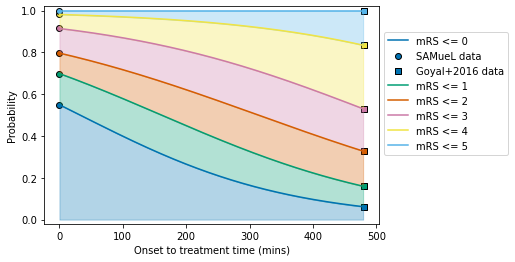

In [16]:
t = np.arange(0,8*60)

plot_probs(A_ect,b_ect,t,mrs_prob_bins_t0_treatment,mrs_prob_bins_no_treatment_ect,colour_bins=1,mark_data_ect=1)

plt.show()

## Model 1 code

Inputs: 

- Time to thrombectomy or thrombolysis
- Time to zero effect (set at 8 hours, but optionally changed)

Outpts:

- Single sample of mRS if untreated, and mRS if treated
- 100 samples of mRS if untreated, and mRS if treated, and probability of mRS being improved by at least 1

In [19]:
def stroke_outcome(mrs_prob_dist_t0_treatment, mrs_prob_dist_no_treatment, treatment_time, time_zero_effect=8*60, single=True, n_iter=100, xs=[]):
    
    '''
    Inputs
    
    mrs_prob_dist_t0_treatment:           1D list or numpy array. Element i corresponds to 
                      the proportion of patients that had mRS=i, before stroke or 
                      if treated at time t=0.
    mrs_prob_dist_no_treatment:           1D list or numpy array. Element i corresponds to 
                      the proportion of patients that had mRS=i if not treated
                      or treated after time_zero_effect
    treatment_time:   int. time in minutes between stroke and treatment    
    time_zero_effect: int. time in minutes after stroke that treatment
                      has no effect.                      
    single:           bool. If True, model will only perform one iteration    
    n_iter:           int. If single=False, number of iterations the model 
                      will perform.
    xs:               1D list or numpy array. List of values of 'x' to try.
                      
    
    Outputs
    
    mRS_0:  1D list. mRS if treated at time t=0     
    mRS_F:  1D list. mRS if treated at time_zero_effect  
    mRS_T:  1D list. mRS if treated at treatment_time
    bins_t: bins at treatment_time
    
    '''

    # find a
    F = np.cumsum(mrs_prob_dist_no_treatment)
    F = F/F[-1]

    p1 = np.log(np.cumsum(mrs_prob_dist_t0_treatment)[:-1])
    p2 = np.log(1- np.cumsum(mrs_prob_dist_t0_treatment)[:-1])
    p3 = np.log(F[:-1])
    p4 = np.log(1-F[:-1])

    a = p1-p2 - p3 + p4

    # find b
    b = -a/(time_zero_effect)

    # find A
    A = a+p3-p4

    # mRS at t=0
    # Get all mRS bins at t=0:
    mrs_prob_bins_t0_treatment = np.cumsum(np.concatenate(([0],mrs_prob_dist_t0_treatment)))


    # mRS untreated
    # Find which bin 'x' lies in at t=time_to_no_effect.
    mrs_prob_bins_no_treatment = np.cumsum(np.concatenate(([0],mrs_prob_dist_no_treatment)))
    mrs_prob_bins_no_treatment = mrs_prob_bins_no_treatment/mrs_prob_bins_no_treatment[-1]
    #print(mrs_prob_bins_no_treatment)
    

    # mRS treated
    # Create the probability bins at treatment_time:
    bins_T = [np.exp(A_i + b[i]*treatment_time)/(1+np.exp(A_i + b[i]*treatment_time))\
                 for i,A_i in enumerate(A)]
    # Find which bin 'x' lies in at t=treatment_time.
    bins_T = np.concatenate((np.concatenate(([0],bins_T)),[1]))
    

    
    if single:
        
        n_iter = 1
    elif len(xs)>0:
        n_iter = len(xs)
        
    count=0
    
    mRS_0, mRS_F, mRS_T = [],[],[]
    
    while count<n_iter:
    
        # random number to represent mRS at t=0.
        # x is a probability on the y-axis and so runs from 0 to 1.

        x = np.random.rand() if len(xs)<1 else xs[count]
        #x = 0.9

        # Find which bin 'x' lies in,
        # i.e. which plotted probability line it lies under,
        # at time t=0, t=treatment_time, and t=time_to_no_effect.
        mRS_0.append(np.digitize(x, mrs_prob_bins_t0_treatment, right=True)-1)
        mRS_F.append(np.digitize(x, mrs_prob_bins_no_treatment, right=True)-1)
        mRS_T.append(np.digitize(x, bins_T, right=True)-1)
    
        if single:
            
            #print(x)

            print(f'mRS pre-stroke: {mRS_0[-1]}')
            print(f'mRS if not treated: {mRS_F[-1]}')
            print(f'mRS if treated at time={treatment_time}: {mRS_T[-1]}')
            
        count+=1

        
    if not single:
        # For all of the patients (n_iter values of 'x'), record whether 
        # their mRS improved (mRS_T, with treatment at treatment_time) compared with
        # their untreated mRS level (in mRS_F). If improved, set to 1, else set to 0.
        # Then take the average of the 1s and 0s across all n_iter patients. 
        treatment_effect = np.mean([1 if mRS_F[i] - T >=1 else 0 for i,T in enumerate(mRS_T)])
        
        print(f'Probability of mRS improving by 1 or more: {treatment_effect}')
        
    
    return mRS_0, mRS_F, mRS_T, bins_T

In [20]:
# treatment_time = np.random.randint(0, 8*60)
# Manually set treatment time and x:
treatment_time = 210
x = 0.75

print(treatment_time)

mRS_0, mRS_F, mRS_T, bins_T = stroke_outcome(mrs_prob_dist_t0_treatment, mrs_prob_dist_no_treatment_ect, treatment_time, time_zero_effect=8*60, xs=[x])

210
mRS pre-stroke: 2
mRS if not treated: 4
mRS if treated at time=210: 3


Plot the three mRS values printed above: 

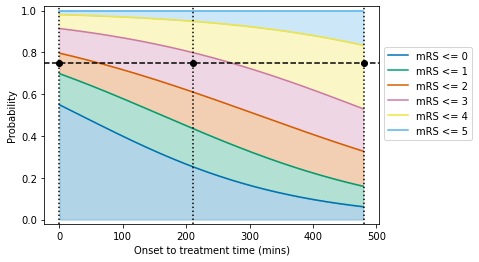

In [21]:
t = np.arange(0,8*60)

# Similar plot to before:
plot_probs(A_ect,b_ect,t,mrs_prob_bins_t0_treatment,mrs_prob_bins_no_treatment_ect,colour_bins=1,mark_data_ect=0)

# Vertical lines at t=0, treatment time, and t=time_to_no_effect:
for t in [0,treatment_time,8*60]:
    plt.axvline(t, color='k', linestyle=':')
    
# Horizontal line where considered 'x' is:
plt.axhline(x, color='k', linestyle='--')
    
# Add scatter markers where the horizontal and vertical lines meet:
for t in [0,treatment_time,8*60]:
    plt.scatter(t,x,color='k',marker='o')
    
    
plt.show()

# # Use tight_layout() to make sure the legend isn't cut off when image is saved:
#plt.tight_layout()
#plt.savefig('lines_prob-mRS_time.pdf')
#plt.close()

---

# Thrombolysis 

Same models, but different `mrs_prob_dist_t0_treatment` and `mrs_prob_dist_no_treatment`.

## T=6.3hrs untreated population

These values are read off Lees+2010 Figure 2 by measuring the widths of the boxes in Powerpoint. 
These measurements are somewhat imprecise so these arrays don't have an integer number of patients in any category, but the categories do sum to the required quantity of patients.

The four bars cover different time ranges, respectively 0-90min, 91-180min, 181-270min, 271-360min. 
These bars have different numbers of patients, respectively 151, 315, 811, 543.
All four bars contain data on mRS=0,...,6 inclusive.

In [25]:
# Untreated population. Four sets of numbers of patients with mRS 0,1,...,5,6:
n_0 = np.array([ 15.91421569,  30.34803922,  16.46936275,  18.38153595,  29.05269608,  10.60947712,  30.2246732 ])
n_1 = np.array([ 46.06617647,  45.42279412,  29.85294118,  51.72794118,  61.12132353,  33.84191176,  46.96691176])
n_2 = np.array([129.53472222, 176.90931373, 108.66339869, 113.96405229, 134.50408497,  64.60171569,  82.82271242])
n_3 = np.array([ 78.96568627, 115.34313725,  72.97671569,  70.09313725, 104.03063725,  47.68995098,  53.90073529])

# Combine the four datasets and create probability distribution:
n_F_oly = np.sum([n_0,n_1,n_2,n_3],axis=0)
# Remove mRS=6 with [:-1]:
mrs_prob_dist_no_treatment_oly = n_F_oly[:-1] / np.sum(n_F_oly[:-1])

# Create cumulative probability:
mrs_prob_bins_no_treatment_oly = np.cumsum(np.concatenate(([0.0],mrs_prob_dist_no_treatment_oly)))

In [26]:
mrs_prob_dist_no_treatment_oly

array([0.16841002, 0.2291431 , 0.14193671, 0.15825232, 0.2046646 ,
       0.09759325])

In [27]:
mrs_prob_bins_no_treatment_oly

array([0.        , 0.16841002, 0.39755312, 0.53948983, 0.69774214,
       0.90240675, 1.        ])

Find the t=0 distribution of probabilities for thrombolysis.
    
The dist is found by scaling the known mRS<=1 odds ratio OR at t=1hr to find the t=0hr equivalent. Then the t=0hr value is used to scale the thrombectomy t=0 values to match. 

In [30]:
OR = 1.9
mRS_ref = 1

In [31]:
# p2 from distribution if not treated
# (index+1 because mrs_prob_bins_no_treatment_oly contains 0.0 at start)
p2 = mrs_prob_bins_no_treatment_oly[mRS_ref+1]

Calculate p1 as in the maths cell above.

In [32]:
p1 = get_p1(p2, OR, T_NE = 6.3)

See plots later in this notebook to better explain the following function. Here t=0 thrombectomy means the SAMueL-1 dataset. 

At this point, we know the probabilities for mRS<=1 at t=0 for both thrombolysis and thrombectomy. The other mRS!=1 probs should be scaled about these points in the same ratios for thrombectomy as for thrombolysis.
     
Basically, at t=0, if the gap A between the mRS=n and mRS=1 lines for thrombectomy is X% of the gap B between 0 (n<1) or 1 (n>1) and the mRS=1 line for thrombectomy, then for thrombolysis the equivalent gap A1 should take up X% of the gap B1.

Find the distributions and bins at time t=0hrs for thrombolysis:

In [33]:
mrs_prob_dist_t0_treatment_oly,mrs_prob_bins_t0_treatment_oly = get_scaled_dist(mrs_prob_dist_t0_treatment,p1,mRS_ref=1)

In [34]:
mrs_prob_dist_t0_treatment_oly

array([0.46101   , 0.12494963, 0.1346828 , 0.16163173, 0.09212051,
       0.02560534])

In [35]:
mrs_prob_bins_t0_treatment_oly

array([0.        , 0.46101   , 0.58595964, 0.72064244, 0.88227417,
       0.97439468, 1.00000001])

## Model 1

Assume log odds = 0 at $T_F$. Then _a_, _b_, and _A_ are calculated in the same way as for thrombectomy.

### Find a

At T = 0, log odds = a

In [36]:
F_oly = np.cumsum(mrs_prob_dist_no_treatment_oly)

F_oly = F_oly/F_oly[-1]

print(F_oly)

p1_oly = np.log(np.cumsum(mrs_prob_dist_t0_treatment_oly)[:-1])
p2_oly = np.log(1 - np.cumsum(mrs_prob_dist_t0_treatment_oly)[:-1])
p3_oly = np.log(F_oly[:-1])
p4_oly = np.log(1 - F_oly[:-1])

a_oly = p1_oly-p2_oly - p3_oly+p4_oly

[0.16841002 0.39755312 0.53948983 0.69774214 0.90240675 1.        ]


In [37]:
a_oly

array([1.44066064, 0.76295839, 0.78936158, 1.17757525, 1.41475922])

### Find b 

At T = 6.3, log odds = 0

In [38]:
b_oly = -a_oly/(6.3*60)

### Find A 

In [39]:
A_oly = a_oly+p3_oly-p4_oly

### Plot log odds as function of time

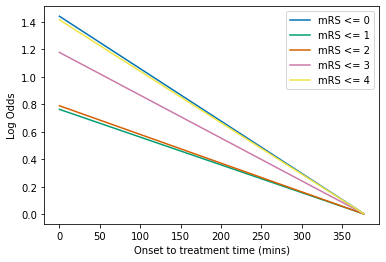

In [40]:
t = np.arange(0,6.3*60)

for i,a_i in enumerate(a_oly):
    
    plt.plot(t, a_i + b_oly[i]*t, '-', label = f'mRS <= {i}')
    
plt.legend(loc='best')

plt.ylabel('Log Odds')

plt.xlabel('Onset to treatment time (mins)')

plt.show()

### Plot P as function of time 

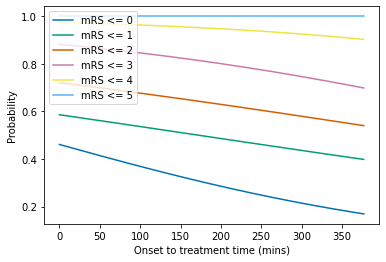

In [41]:
t = np.arange(0,6.3*60)

for i,A_i in enumerate(A_oly):
    
    plt.plot(t, np.exp(A_i + b_oly[i]*t)/(1+np.exp(A_i + b_oly[i]*t)), '-', label = f'mRS <= {i}')

plt.plot(t, [1.0 for x in t], '-', label = 'mRS <= 5')
    
plt.legend(loc='upper left')

plt.ylabel('Probability')

plt.xlabel('Onset to treatment time (mins)')

plt.show()

### Get errors from Emberson's CI, assuming log odds = 0 at T_F

Calculate a new distribution at time=0 using the known $\pm$ values on the odds ratio at time T=1hr for mRS$\leq$1. OR was 1.9. 

Then follow this through to each of the other mRS distributions - use the scaling of the high and low t=0 mRS$\leq$1 points in the same way as before.

In [47]:
def get_mrs_prob_dist_t0_treatment(mrs_prob_dist_t0_treatment,p2,OR,mRS_ref,time_to_no_effect= 6.3):
    """Combine two functions from earlier."""
    p1 = get_p1(p2, OR, time_to_no_effect)
    mrs_prob_dist_t0_treatment_oly,mrs_prob_bins_t0_treatment_oly = get_scaled_dist(mrs_prob_dist_t0_treatment,p1,mRS_ref)
    return mrs_prob_dist_t0_treatment_oly,mrs_prob_bins_t0_treatment_oly 

In [48]:
OR = 1.9
OR_low = 1.4
OR_hi = 2.6

mRS_ref = 1

# p2 from distribution if not treated
# (index+1 because mrs_prob_bins_no_treatment_oly contains 0.0 at start)
p2 = mrs_prob_bins_no_treatment_oly[mRS_ref+1]

In [49]:
d_low,_ = get_mrs_prob_dist_t0_treatment(mrs_prob_dist_t0_treatment,p2,OR_low,mRS_ref)
d_hi,_  = get_mrs_prob_dist_t0_treatment(mrs_prob_dist_t0_treatment,p2,OR_hi, mRS_ref)

#### Lower limit 

In [50]:
p1 = np.log(np.cumsum(d_low)[:-1])
p2 = np.log(1 - np.cumsum(d_low)[:-1])
p3 = np.log(F_oly[:-1])
p4 = np.log(1 - F_oly[:-1])

a_low = p1-p2 - p3+p4

In [51]:
b_low = -a_low/(6.3*60)

In [52]:
A_low = a_low+p3-p4

#### Upper limit 

In [53]:
p1 = np.log(np.cumsum(d_hi)[:-1])
p2 = np.log(1 - np.cumsum(d_hi)[:-1])
p3 = np.log(F_oly[:-1])
p4 = np.log(1 - F_oly[:-1])

a_hi = p1-p2 - p3+p4

In [54]:
b_hi = -a_hi/(6.3*60)

In [55]:
A_hi = a_hi+p3-p4

### Plot P as function of time 

n.b. no errors for mRS=5yet so just plotted the base line:

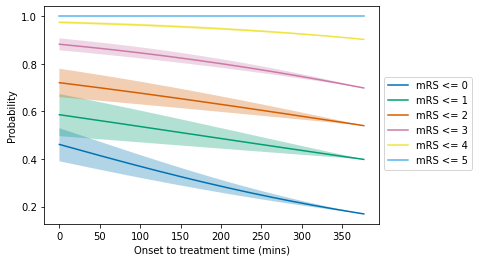

In [56]:
t = np.arange(0,6.3*60)

for i,A_i in enumerate(A_oly):
    
    p_i   = np.exp(A_i      + b_oly[i]*t) / (1+np.exp(A_i      + b_oly[i]*t))
    p_low = np.exp(A_low[i] + b_low[i]*t) / (1+np.exp(A_low[i] + b_low[i]*t))
    p_hi  = np.exp(A_hi[i]  + b_hi[i]*t ) / (1+np.exp(A_hi[i]  + b_hi[i]*t) )
    
    plt.plot(t, p_i, '-', label = f'mRS <= {i}')
    
    plt.fill_between(t, p_low, p_hi, alpha=0.3)

    
plt.plot(t, [1.0 for x in t], '-', label = 'mRS <= 5')

plt.legend(loc='best',bbox_to_anchor=[1.0,0.5,0.2,0.2])

plt.ylabel('Probability')

plt.xlabel('Onset to treatment time (mins)')

plt.show()